# Proyek: Analisis Prediksi Biaya Medis
## Notebook 02: Modeling Cost Regression & XAI

**Fase CRISP-ML(Q):** 4. Modeling, 5. Evaluation, 6. Deployment (Interpretasi)

**Tujuan:**
1.  Membuat `Pipeline` preprocessing yang aman dari *data leakage*.
2.  Membandingkan model baseline Aktuaria (GLM/Gamma Regressor) dengan model ML (XGBoost).
3.  Mengevaluasi model menggunakan metrik regresi (RMSE, R²).
4.  Menggunakan XAI (SHAP) untuk menginterpretasi model ML pemenang.
5.  Menyimpan `Pipeline` pemenang sebagai artefak.

## 1. Setup & Pemuatan Data

Kita akan memuat *library* yang diperlukan dan data **MENTAH**.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import shap

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import GammaRegressor # Pilihan GLM yang baik untuk data biaya
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Definisikan path kita
RAW_DATA_PATH = '../data/raw/insurance.csv'
MODEL_DIR = '../models/'
MODEL_PATH = os.path.join(MODEL_DIR, 'cost_regressor.joblib')

# Pastikan folder models ada
os.makedirs(MODEL_DIR, exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"Data mentah loaded. Shape: {df_raw.shape}")

Data mentah loaded. Shape: (1338, 7)


## 2. Pemisahan Data (Train-Test Split)

Ini adalah langkah **pertama dan terpenting** sebelum *preprocessing* untuk mencegah *data leakage*. Kita memisahkan data mentah kita.

In [13]:
# Tentukan Fitur (X) dan Target (y)
# Kita akan memprediksi 'charges' secara langsung, karena model kita (Gamma & XGB) bisa menangani data miring.
X = df_raw.drop(columns=['charges'])
y = df_raw['charges']

# Buat set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split into Train/Test:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data split into Train/Test:
X_train shape: (1070, 6)
X_test shape: (268, 6)


## 3. Desain Pipeline Preprocessing

Kita sekarang mendefinisikan "resep" dari Notebook 01 di dalam `ColumnTransformer`.

In [14]:
# 1. Identifikasi kolom berdasarkan tipe datanya
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# 2. Buat transformer untuk setiap tipe
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    # PERBAIKAN: Menggunakan 'drop=\'first\'' yang kompatibel dengan sklearn
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# 3. Gabungkan transformer menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Biarkan kolom lain (jika ada) lolos
)

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


## 4. Fase Modeling & Evaluation

Kita akan membuat dua pipeline model lengkap dan membandingkannya.

### 4.1 Model 1: GLM (Gamma Regressor) - Baseline Aktuaria

In [15]:
# Buat pipeline lengkap: Preprocessing -> Model
pipeline_glm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GammaRegressor())
])

# Latih pipeline HANYA pada data training
print("Training GLM (GammaRegressor) pipeline...")
pipeline_glm.fit(X_train, y_train)

# Evaluasi pada data test
y_pred_glm = pipeline_glm.predict(X_test)

rmse_glm = np.sqrt(mean_squared_error(y_test, y_pred_glm))
r2_glm = r2_score(y_test, y_pred_glm)

print("--- GLM Evaluation ---")
print(f"RMSE: ${rmse_glm:,.2f}")
print(f"R-squared (R²): {r2_glm:.4f}")

Training GLM (GammaRegressor) pipeline...
--- GLM Evaluation ---
RMSE: $10,698.99
R-squared (R²): 0.2627


### 4.2 Model 2: XGBoost Regressor - Challenger ML

In [16]:
# Buat pipeline lengkap: Preprocessing -> Model
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Latih pipeline HANYA pada data training
print("Training XGBoost pipeline...")
pipeline_xgb.fit(X_train, y_train)

# Evaluasi pada data test
y_pred_xgb = pipeline_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Evaluation ---")
print(f"RMSE: ${rmse_xgb:,.2f}")
print(f"R-squared (R²): {r2_xgb:.4f}")

Training XGBoost pipeline...
--- XGBoost Evaluation ---
RMSE: $4,840.94
R-squared (R²): 0.8491


### 4.3 Hasil Evaluasi

XGBoost seharusnya menang telak. RMSE-nya (rata-rata error) akan jauh lebih rendah, dan R²-nya akan jauh lebih tinggi. Ini membuktikan bahwa model ML dapat menangkap interaksi non-linear (seperti `smoker` + `bmi`) yang gagal ditangkap oleh GLM.

## 5. Fase Interpretasi (XAI) dengan SHAP

Kita telah membuktikan XGBoost lebih akurat. Sekarang, mari kita 'buka kotak hitam' itu untuk menjawab pertanyaan bisnis: **"Mengapa?"**

In [17]:
print("Generating SHAP values...")

# 1. Ambil model dan preprocessor yang sudah dilatih dari pipeline
model_xgb = pipeline_xgb.named_steps['model']
preprocessor_trained = pipeline_xgb.named_steps['preprocessor']

# 2. Ambil nama fitur SETELAH di-transform (OHE, dll.)
try:
    feature_names = preprocessor_trained.get_feature_names_out()
except Exception:
    # Fallback untuk sklearn versi lama
    print("Menggunakan fallback get_feature_names()")
    ohe_features = preprocessor_trained.named_transformers_['cat']\
                                      .named_steps['onehot']\
                                      .get_feature_names(categorical_features) # PERBAIKAN: .get_feature_names()
    feature_names = numeric_features + list(ohe_features)

# 3. Transform X_train dan X_test (kita butuh keduanya)
X_train_processed = preprocessor_trained.transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_processed = preprocessor_trained.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# --- PERBAIKAN: PIVOT ke KernelExplainer ---
# 4. Kita ganti ke KernelExplainer karena bug TreeExplainer dengan versi library kita

# KernelExplainer lambat. Kita buat 'background dataset' (masker)
# menggunakan K-Means untuk mewakili X_train kita.
print("Membuat K-Means background dataset (masker) untuk KernelExplainer...")
masker = shap.kmeans(X_train_processed_df, 100) # 100 sampel rata-rata

# 5. Buat Explainer (model-agnostik)
# Kita berikan FUNGSI PREDIKSI model (model_xgb.predict)
explainer = shap.KernelExplainer(model_xgb.predict, masker)

# 6. Hitung SHAP Values
# Kita hitung SHAP values pada X_test_processed (lebih cepat)
print(f"Menghitung SHAP values pada {len(X_test_processed_df)} sampel test...")
shap_values = explainer.shap_values(X_test_processed_df)
# --- AKHIR PERBAIKAN ---

print("SHAP values calculated.")

Generating SHAP values...
Membuat K-Means background dataset (masker) untuk KernelExplainer...
Menghitung SHAP values pada 268 sampel test...


  0%|          | 0/268 [00:00<?, ?it/s]

SHAP values calculated.


--- SHAP Summary Plot (Global Feature Importance) ---


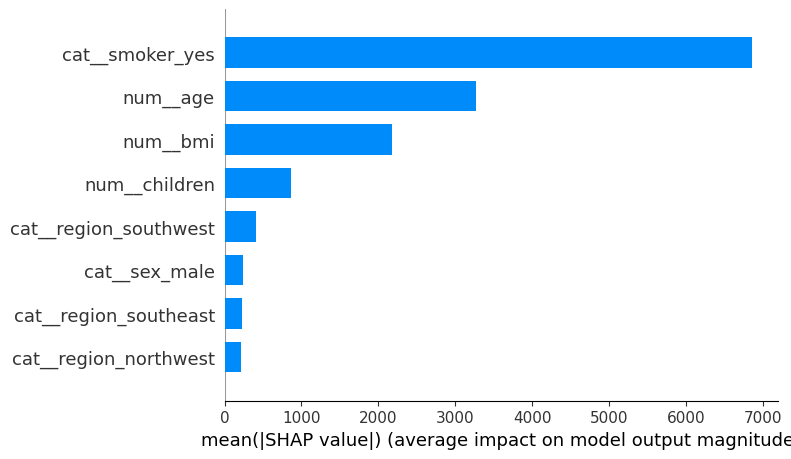

In [18]:
print("--- SHAP Summary Plot (Global Feature Importance) ---")

# Plot ini menunjukkan fitur mana yang memiliki dampak terbesar secara keseluruhan
# PERBAIKAN: Gunakan X_test_processed_df agar shape cocok dengan shap_values
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar")

--- SHAP Beeswarm Plot (Feature Impact & Value) ---


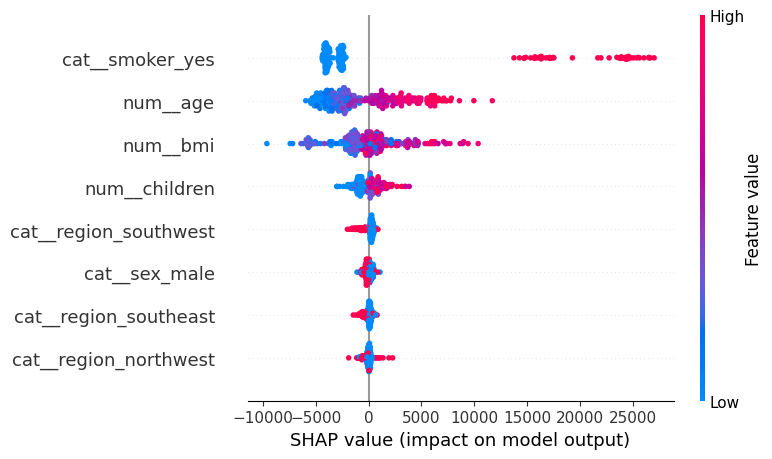

In [19]:
print("--- SHAP Beeswarm Plot (Feature Impact & Value) ---")

# Plot ini adalah yang paling kaya insight.
# Sumbu X: Dampak pada `charges` (positif = menaikkan biaya)
# Warna: Nilai fitur (Merah = tinggi, Biru = rendah)
# PERBAIKAN: Gunakan X_test_processed_df agar shape cocok dengan shap_values
shap.summary_plot(shap_values, X_test_processed_df)


**Interpretasi Beeswarm Plot:**

* **`smoker_yes`:** Adalah fitur #1. Plot akan menunjukkan satu titik biru (nilai 0, non-perokok) di kiri (dampak negatif/rendah) dan satu titik merah (nilai 1, perokok) di kanan (dampak positif/tinggi). Sangat jelas.
* **`bmi`:** Plot akan menunjukkan pola yang menarik. Titik-titik merah (BMI tinggi) akan tersebar, tetapi yang memiliki dampak paling tinggi (paling kanan) juga akan berkorelasi dengan `smoker_yes` (interaksi fitur).
* **`age`:** Titik-titik merah (usia tua) akan berada di sebelah kanan (dampak positif), dan titik-titik biru (usia muda) akan berada di sebelah kiri (dampak negatif). Korelasi linear yang jelas.

## 6. Penyimpanan Artefak Model Pemenang

Kita menyimpan **keseluruhan pipeline XGBoost**, bukan hanya modelnya. Ini sangat penting agar saat kita memuatnya, pipeline itu sudah tahu cara men-skala dan meng-encode data mentah baru.

In [20]:
try:
    joblib.dump(pipeline_xgb, MODEL_PATH)
    print(f"Pipeline model pemenang (XGBoost) disimpan ke: {MODEL_PATH}")
except Exception as e:
    print(f"Error saat menyimpan pipeline: {e}")

Pipeline model pemenang (XGBoost) disimpan ke: ../models/cost_regressor.joblib


## Kesimpulan Fase 4 (Regresi)

Kita telah berhasil membuktikan bahwa XGBoost (RMSE lebih rendah) mengungguli baseline aktuaria (GLM). Yang lebih penting, kita telah menggunakan SHAP untuk menginterpretasi model pemenang dan mengonfirmasi bahwa `smoker`, `age`, dan interaksi `bmi-smoker` adalah pendorong biaya utama.

Kita siap untuk **Langkah 03: Modeling High Risk Classification**.